### Parameter Tuning with Gradient Boosting for Regression
- [Data Loading and Preprocessing](#load)
- [Parameter Tuning](#tune)
    - [Results](#tune_results)
- [Parameter Tuning](#tune_with_displacement) (include _displacement_)
    - [Results](#tune_with_displacement_results)
- [Model with default parameters and results](#baseline)
- [Model with default parameters and results](#baseline_with_displacement) (include _displacement_)
- [Result Comparison](#compare_results)
- [Summary](#summary)

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import project_path
from core import data_util, nb_util

%matplotlib inline

### Load and preprocess data <a id="load"></a>

Data will be loaded, cleaned, and split. The training data will be preprocessed with two different ColumnTransformers created in _02_preprocess_ notebook. The ColumnTransformer object, _pp_, does <u>not</u> include _displacement_ as input feature, whereas ColumnTransformer object, _pp_wd_, includes _displacement_. We will perform parameter tuning with each input set and compare the scores. 

_Note:_ In feature exploration phase, we found _displacement_ to be very strongly correlated to _cylinders_ and _weight_.

In [2]:
DATA_PATH = 'data/auto-mpg.data'
COLUMNS = ['mpg', 'cylinders', 'displacement', 'horsepower', 
           'weight', 'acceleration', 'year', 'origin', 'name']
X_tn, X_ts, y_tn, y_ts = data_util.load_clean_split(DATA_PATH, COLUMNS, 'mpg', test_size=0.2)

In [3]:
# Preprocess using ColumnTransformer object
pp = pickle.load(open('data/preprocessor.pkl', 'rb'))
col_list = data_util.get_column_names_from_ColumnTransformer(pp)
pp_X_tn = pp.transform(X_tn)
pp_X_ts = pp.transform(X_ts)

# Convert DataFrame to 1-D array
y_tn = y_tn.values.ravel() if not isinstance(y_tn, np.ndarray) else y_tn
y_ts = y_ts.values.ravel() if not isinstance(y_ts, np.ndarray) else y_ts

# Preprocess using ColumnTransformer object (include displacement)
pp_wd = pickle.load(open('data/preprocessor_w_displacement.pkl', 'rb'))
col_list_wd = data_util.get_column_names_from_ColumnTransformer(pp_wd)
pp_X_tn_wd = pp_wd.transform(X_tn)
pp_X_ts_wd = pp_wd.transform(X_ts)

In [4]:
# Dataframe for scores
df_scores = pd.DataFrame(columns=['mae', 'r2'])

### Parameter Tuning <u>without</u> _displacement_ <a id="tune"></a> 

In [5]:
# Search space
param_grid = {'n_estimators': [100, 200, 500, 1000],
              'max_depth': [1, 2, 4],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.25, 0.5, 0.75, 1]
             }
gbregressor = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbregressor, param_grid=param_grid,
                           scoring=['neg_mean_absolute_error', 'r2'],
                           cv=5, n_jobs=-1, verbose=2, refit='r2')
grid_search.fit(pp_X_tn, y_tn)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   34.3s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 4],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.25, 0.5, 0.75, 1]},
             refit='r2', scoring=['neg_mean_absolute_error', 'r2'], verbose=2)

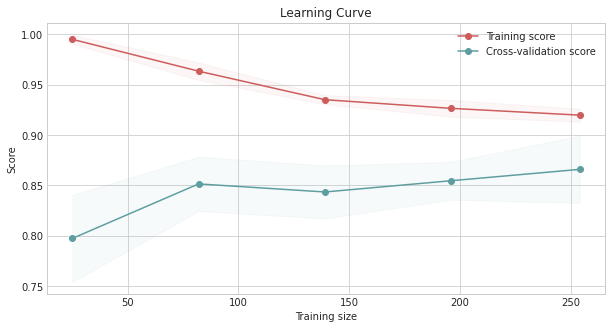

In [6]:
tuned_model = grid_search.best_estimator_
nb_util.plot_learning_curve(tuned_model, pp_X_tn, y_tn, 
                            title='Learning Curve', figsize=(10, 5))

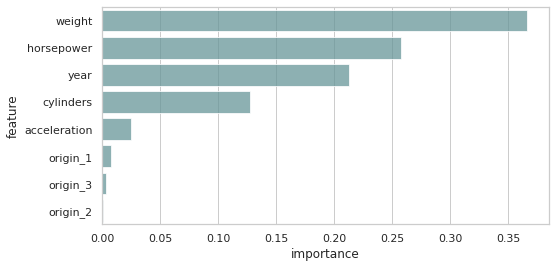

In [7]:
nb_util.plot_feature_importances(col_list,
                                 list(tuned_model.feature_importances_),
                                 color='cadetblue', alpha=0.75)

#### Results: Tuned Model <u>without</u> _displacement_ <a id="tune_results"></a> 

In [8]:
# Predict
y_tn_hat = tuned_model.predict(pp_X_tn)
y_ts_hat = tuned_model.predict(pp_X_ts)
# Train scores
mae_tn = mean_absolute_error(y_tn, y_tn_hat)
r2_tn = r2_score(y_tn, y_tn_hat)
# Test scores
mae_ts = mean_absolute_error(y_ts, y_ts_hat)
r2_ts = r2_score(y_ts, y_ts_hat)

df_scores.loc['tuned_model'] = [np.nan, np.nan]
df_scores.loc['tuned_model_tn'] = [mae_tn, r2_tn]
df_scores.loc['tuned_model_ts'] = [mae_ts, r2_ts]

nb_util.print_results(tuned_model, col_list, title='Tuned Model',
                      mae_tn=mae_tn, r2_tn=r2_tn, 
                      mae_ts=mae_ts, r2_ts=r2_ts)


Results: Tuned Model
Model: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=500,
                          random_state=42, subsample=0.5)
Features: origin_1, origin_2, origin_3, horsepower, weight, acceleration, cylinders, year

Train MAE score: 1.705
Train R2 score: 0.916

Test MAE score: 1.800
Test R2 score: 0.896



### Parameter Tuning <u>with</u> _displacement_ <a id="tune_with_displacement"></a>

In [9]:
grid_search_wd = GridSearchCV(estimator=gbregressor, param_grid=param_grid,
                           scoring=['neg_mean_squared_error', 'r2'],
                           cv=5, n_jobs=-1, verbose=2, refit='r2')
grid_search_wd.fit(pp_X_tn_wd, y_tn)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 469 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   36.1s finished


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [1, 2, 4],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.25, 0.5, 0.75, 1]},
             refit='r2', scoring=['neg_mean_squared_error', 'r2'], verbose=2)

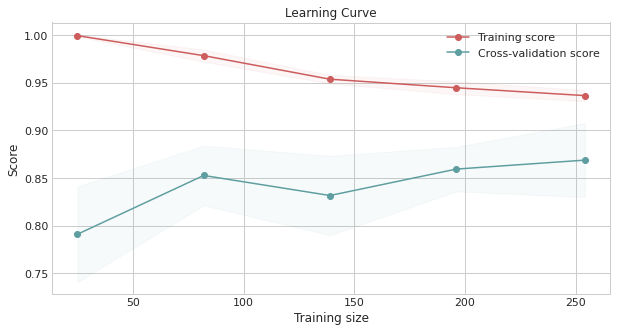

In [10]:
tuned_model_wd = grid_search_wd.best_estimator_
nb_util.plot_learning_curve(tuned_model_wd, pp_X_tn_wd, y_tn, 
                            title='Learning Curve', figsize=(10, 5))

#### Results: Tuned Model <u>with</u> _displacement_ <a id="tune_with_displacement_results"></a>

In [11]:
# Predict
y_tn_hat_wd = tuned_model_wd.predict(pp_X_tn_wd)
y_ts_hat_wd = tuned_model_wd.predict(pp_X_ts_wd)
# Train scores
mae_tn_wd = mean_absolute_error(y_tn, y_tn_hat_wd)
r2_tn_wd = r2_score(y_tn, y_tn_hat_wd)
# Test scores
mae_ts_wd = mean_absolute_error(y_ts, y_ts_hat_wd)
r2_ts_wd = r2_score(y_ts, y_ts_hat_wd)

df_scores.loc['tuned_model_wd'] = [np.nan, np.nan]
df_scores.loc['tuned_model_wd_tn'] = [mae_tn_wd, r2_tn_wd]
df_scores.loc['tuned_model_wd_ts'] = [mae_ts_wd, r2_ts_wd]

nb_util.print_results(tuned_model_wd, col_list_wd, title='Tuned Model (with displacement)', 
                      mae_tn=mae_tn_wd, r2_tn=r2_tn_wd, 
                      mae_ts=mae_ts_wd, r2_ts=r2_ts_wd)


Results: Tuned Model (with displacement)
Model: GradientBoostingRegressor(learning_rate=0.05, max_depth=1, n_estimators=1000,
                          random_state=42, subsample=0.75)
Features: origin_1, origin_2, origin_3, horsepower, weight, acceleration, displacement, cylinders, year

Train MAE score: 1.541
Train R2 score: 0.931

Test MAE score: 1.897
Test R2 score: 0.881



### Default model <u>without</u> _displacement_ and results <a id="baseline"></a>

In [12]:
# Fit with default parameters
baseline_model = GradientBoostingRegressor(random_state=42)
baseline_model.fit(pp_X_tn, y_tn)
# Predict
y_tn_hat_bl = baseline_model.predict(pp_X_tn)
y_ts_hat_bl = baseline_model.predict(pp_X_ts)
# Train scores
mae_tn_bl = mean_absolute_error(y_tn, y_tn_hat_bl)
r2_tn_bl = r2_score(y_tn, y_tn_hat_bl)
# Test scores
mae_ts_bl = mean_absolute_error(y_ts, y_ts_hat_bl)
r2_ts_bl = r2_score(y_ts, y_ts_hat_bl)

df_scores.loc['baseline_model'] = [np.nan, np.nan]
df_scores.loc['baseline_model_tn'] = [mae_tn_bl, r2_tn_bl]
df_scores.loc['baseline_model_ts'] = [mae_ts_bl, r2_ts_bl]

nb_util.print_results(baseline_model, col_list, title='Baseline Model', 
                      mae_tn=mae_tn_bl, r2_tn=r2_tn_bl, 
                      mae_ts=mae_ts_bl, r2_ts=r2_ts_bl)


Results: Baseline Model
Model: GradientBoostingRegressor(random_state=42)
Features: origin_1, origin_2, origin_3, horsepower, weight, acceleration, cylinders, year

Train MAE score: 1.141
Train R2 score: 0.965

Test MAE score: 1.831
Test R2 score: 0.878



### Default model <u>with</u> _displacement_ and results <a id="baseline_with_displacement"></a>

In [13]:
# Fit with default parameters
baseline_model_wd = GradientBoostingRegressor(random_state=42)
baseline_model_wd.fit(pp_X_tn_wd, y_tn)
# Predict
y_tn_hat_bl_wd = baseline_model_wd.predict(pp_X_tn_wd)
y_ts_hat_bl_wd = baseline_model_wd.predict(pp_X_ts_wd)
# Train scores
mae_tn_bl_wd = mean_absolute_error(y_tn, y_tn_hat_bl_wd)
r2_tn_bl_wd = r2_score(y_tn, y_tn_hat_bl_wd)
# Test scores
mae_ts_bl_wd = mean_absolute_error(y_ts, y_ts_hat_bl_wd)
r2_ts_bl_wd = r2_score(y_ts, y_ts_hat_bl_wd)

df_scores.loc['baseline_model_wd'] = [np.nan, np.nan]
df_scores.loc['baseline_model_wd_tn'] = [mae_tn_bl_wd, r2_tn_bl_wd]
df_scores.loc['baseline_model_wd_ts'] = [mae_ts_bl_wd, r2_ts_bl_wd]

nb_util.print_results(baseline_model_wd, col_list_wd, title='Baseline Model (with displacement)',
                      mae_tn=mae_tn_bl_wd, r2_tn=r2_tn_bl_wd, 
                      mae_ts=mae_ts_bl_wd, r2_ts=r2_ts_bl_wd)


Results: Baseline Model (with displacement)
Model: GradientBoostingRegressor(random_state=42)
Features: origin_1, origin_2, origin_3, horsepower, weight, acceleration, displacement, cylinders, year

Train MAE score: 0.996
Train R2 score: 0.974

Test MAE score: 1.764
Test R2 score: 0.900



### All Result Comparison <a id="compare_results"></a>

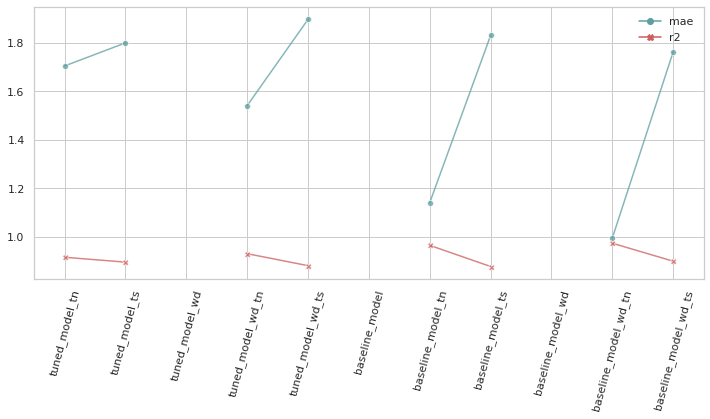

In [14]:
g = sns.set(rc={'figure.figsize': (12, 5)})
g = sns.set_style('whitegrid')
plt.xticks(rotation=75)
g = sns.lineplot(data=df_scores, palette=['cadetblue', 'indianred'], 
                 alpha=0.75, dashes=False, markers=True)

<div class="alert alert-info">
    <strong>Summary:</strong>
    <ul>
        <li>Both baseline models are overfitted as test scores are significantly worse than training scores (both MAE and R2). Notice high slopes in the above chart for baseline model scores.</li>
        <li>As expected, tuned model that does not include <i>displacement</i> outperforms tuned model with <i>displacement</i></li> Among all models, it has the smallest distances between training and testing scores and best testing scores.
    </ul>
</div>

#### Serialize tuned model 

In [15]:
# pickle tuned_model
ESTIMATOR_NAME = 'gbregressor'
FILENAME = '-'.join(''.join(map(str,each)) 
                    for each in grid_search.best_params_.items()).replace('.', 'p')
MODEL_FILE_PATH = 'data/{}-{}.pkl'.format(ESTIMATOR_NAME, FILENAME)

pickle.dump(tuned_model, 
            open(MODEL_FILE_PATH, 'wb'))

In [16]:
%time tmp_model = pickle.load(open(MODEL_FILE_PATH, 'rb'))
%time tmp_encoder = pickle.load(open('data/origin_encoder.pkl', 'rb'))

# Encode 'origin'
mockup_input = [each for each in tmp_encoder.transform([[3]]).toarray().tolist()]
# Include the rest of input features
mockup_input = list(data_util.flatten(mockup_input + [68.0, 1985.0, 15.0, 4, 89]))
# Predict
tmp_model.predict([mockup_input])[0]

CPU times: user 14 ms, sys: 0 ns, total: 14 ms
Wall time: 16.4 ms
CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 4.32 ms


37.58472676826936